In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
#워닝 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [4]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DSL/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [118]:
#10000개만 사용한다
imsi = fashion[:10000]

#나름 어느정도 균등하게 뽑힌 것을 확인할 수 있다
imsi['label'].value_counts()

7    1037
9    1036
6    1022
3    1012
0    1009
5    1008
4     979
8     974
1     972
2     951
Name: label, dtype: int64

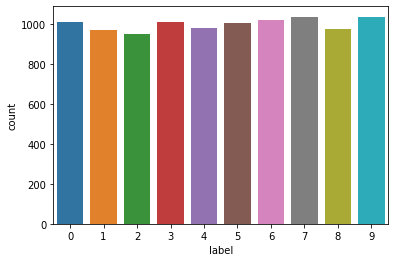

In [120]:
sns.countplot(imsi['label']) #y라벨이 균등하게 분포하는지 확인
plt.show()

In [121]:
#raw_y, raw_X 데이터 만들기
raw_y = imsi['label']
raw_X = imsi.drop(['label'], axis = 1)

In [122]:
#훈련 세트, 테스트 세트 분리하기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size = 0.2, stratify = raw_y, random_state = 1)

In [123]:
#X_train 확인해보기
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
4040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
591,0,0,0,0,0,0,0,0,0,0,...,25,31,55,0,0,0,1,0,0,0
1646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
#y_test 확인해보기
y_test.head()

453     0
8120    3
9958    0
9674    5
4319    3
Name: label, dtype: int64

In [125]:
#나름 어느정도 균등하게 뽑힌 것을 확인할 수 있다
print(y_train.value_counts())
print("=" * 30)
print(y_test.value_counts())

7    830
9    829
6    818
3    810
0    807
5    806
4    783
8    779
1    777
2    761
Name: label, dtype: int64
7    207
9    207
6    204
0    202
3    202
5    202
4    196
8    195
1    195
2    190
Name: label, dtype: int64


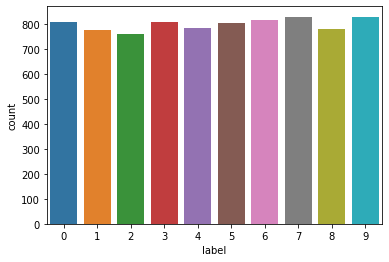

In [126]:
sns.countplot(y_train) #y라벨이 균등하게 분포하는지 확인
plt.show()

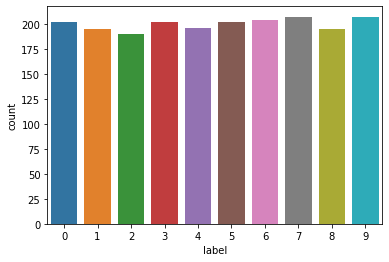

In [127]:
sns.countplot(y_test) #y라벨이 균등하게 분포하는지 확인
plt.show()

In [128]:
#인덱스 순서 재할당 - 안 하면 아래 코드가 실행되지 않음
y_train.reset_index(drop = True, inplace=True)
X_train.reset_index(drop = True, inplace=True)
y_test.reset_index(drop = True, inplace=True)
X_test.reset_index(drop = True, inplace=True)

- 어떻게 생긴 데이터셋인지 확인해보기

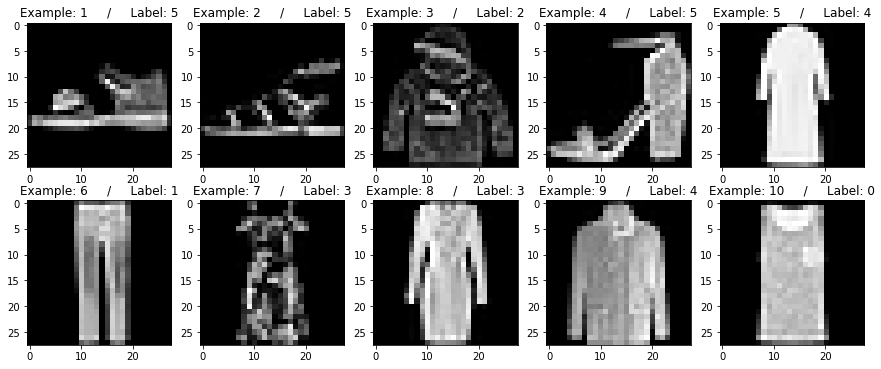

In [129]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [130]:
#일단 784개 차원 그대로 사용해서 모델을 만들어보자
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #784차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(8000, 784)

In [131]:
#각각의 주성분들이 설명하는 분산이 어느정도 되는가?
pca.explained_variance_ratio_[:10]

array([0.29039872, 0.17561323, 0.0607383 , 0.05110313, 0.03752599,
       0.03475381, 0.02303379, 0.01979464, 0.01370423, 0.01332341])

첫 두 변수가 설명하는 분산이 각각 29%, 18%로 설명력이 매우 높은 것을 확인할 수 있다. 이후 변수가 추가될 수록 설명력이 줄어드는 것도 확인할 수 있다.

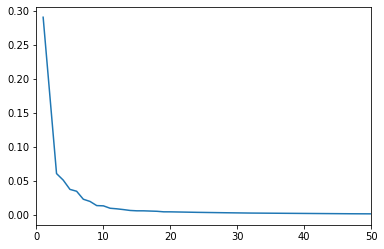

In [132]:
#그림으로 확인
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

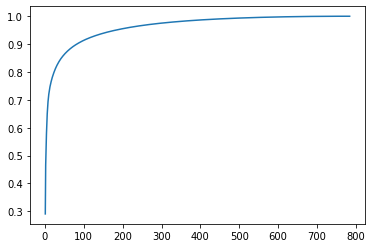

In [133]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [134]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 72.00%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.52%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.33%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.36%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [135]:
cumulative=np.array(cumulative)
np.where(cumulative>0.90)[0][0] #81개 쓰면 분산의 90%이상을 설명

81

81개의 입력 변수를 사용하면 분산의 90% 이상을 설명할 수 있다. 90%를 기준으로 차원축소를 진행해보겠다.

In [136]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=81)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (8000, 784)
After PCA: (8000, 81)


- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


#### 1. Logistic Regression

In [137]:
#차원축소 이전(origianl 공간 784차원)
start=time.time()
logistic_original=LogisticRegression()
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.906375
test accuracy: 0.819
9.4531sec


In [138]:
#차원축소 이후(81차원)
start=time.time()
logistic_pca=LogisticRegression() 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.86475
test accuracy: 0.837
1.4745sec


- PCA 이후 학습 속도가 크게 개선됨
- PCA 이전과 이후에 train accuracy는 차이가 많이 나지만, test accuracy는 오히려 PCA 이후가 높다. 
- PCA 이전 모델은 학습데이터에 과적합된 것으로 보이는 반면, PCA 이후 모델은 잘 일반화된 모델로 보인다.
- PCA 이후의 로지스틱 회귀 모델이 더 빠르고 좋은 성능을 내는 것을 확인할 수 있으며, 과적합에 강한 것을 확인할 수 있다. 

#### 2. Random Forest

In [139]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.857
12.2880sec


In [140]:
#차원축소 이후(81차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8495
11.4810sec


- 차원축소 이후 학습시간이 크게 감소하지 않는 것을 확인할 수 있다 (애초에 Random Forest가 병렬적 학습이기 때문에 원래 학습속도가 그렇게 느리지 않음)
- 성능 역시 PCA 이전이 미세하게 더 높음.
- random forest의 경우, decision tree를 병렬적으로 여러개 사용하면서 DT가 야기할 수 있는 과적합 문제를 이미 어느정도는 해결하고 있는 앙상블 기법이기에 PCA를 통해 더 개선되지X
- 차원축소는 만능 해결책이 아니며, 과적합이나 다중공선성이 critical한 문제로 인식될 때 써볼 수 있는 하나의 방법이다!

#### 3. XGBoost

In [56]:
#차원축소 이전
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.931125
test accuracy: 0.853
182.7958sec


In [57]:
#차원축소 이후
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.911
test accuracy: 0.831
57.8227sec


- 차원축소 이후 학습시간이 크게 감소함.(XGBoost는 순차적 학습이기 때문에 시간이 크게 감소)
- 더 빠른 속도로 비슷한 성능을 내는 것을 확인할 수 있다.

### 4. Decision Tree (max_depth = 10)

In [65]:
#차원축소 이전
from sklearn.tree import DecisionTreeClassifier
start=time.time()
tree_original = DecisionTreeClassifier(random_state = 1, max_depth = 10)
tree_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, tree_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, tree_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.886
test accuracy: 0.758
3.1636sec


In [66]:
#차원축소 이후
from sklearn.tree import DecisionTreeClassifier
start=time.time()
tree_pca = DecisionTreeClassifier(random_state = 1, max_depth = 10)
tree_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, tree_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, tree_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.83975
test accuracy: 0.7345
0.8600sec


- 차원축소 이후 학습시간이 크게 감소함.
- 더 빠른 속도로 비슷한 성능을 내는 것을 확인할 수 있다.

### 5. SVM (kernel = 'rbf')

In [68]:
#차원 축소 이전
from sklearn.svm import SVC
start = time.time()
svm_original = SVC(kernel = 'rbf')
svm_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, svm_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, svm_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.897125
test accuracy: 0.86
64.0127sec


In [69]:
#차원 축소 이후
from sklearn.svm import SVC
start = time.time()
svm_pca = SVC(kernel = 'rbf')
svm_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, svm_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, svm_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.888
test accuracy: 0.859
7.6332sec


- 차원축소 이후 학습시간이 크게 감소함.
- 더 빠른 속도로 비슷한 성능을 내는 것을 확인할 수 있다.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

#### 1. PCA

- 분산을 크게하는 잠재변수 찾기

In [141]:
#2차원으로 표현하기 위해 2차원으로 차원 축소 시행
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

1.0983sec


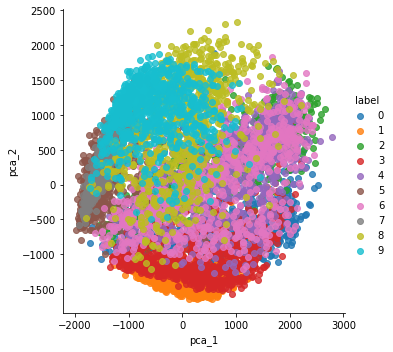

In [142]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

2. MDS

- 고차원에서의 거리 정보를 최대한 유지하는 저차원의 공간을 찾자

In [72]:
#시간 엄청 오래 걸림
from sklearn.manifold import MDS
start=time.time()
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

2651.4914sec


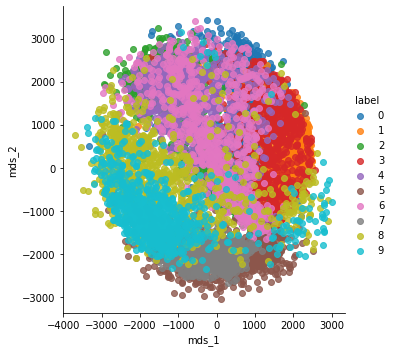

In [73]:
X_train_mds=pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds=pd.concat((X_train_mds, y_train), axis=1) 
X_train_mds.columns=['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

## LDA
- class(label)을 잘 구분해주는 축을 찾자

In [143]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

3.9561sec


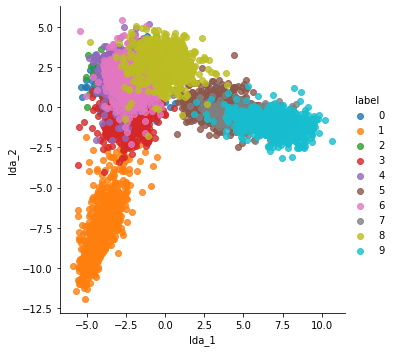

In [144]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

## KPCA

- 고차원에서 분산을 크게 해주는 축을 찾자
- 데이터의 형태에 따라 적절한 커널 및 하이퍼파라미터을 사용해줄 필요 있음.

kernel = "rdf", gamma = 0.001 인 경우

In [171]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.001, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

41.6919sec


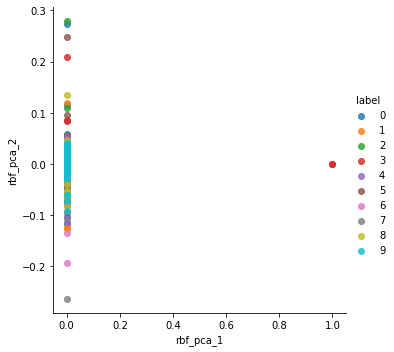

In [172]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

kernel = "poly", gamma = 0.1 인 경우

In [173]:
start=time.time()
poly_pca = KernelPCA(n_components = 2, kernel="poly", gamma=0.1, coef0=1)
X_train_poly_pca=poly_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

11.3408sec


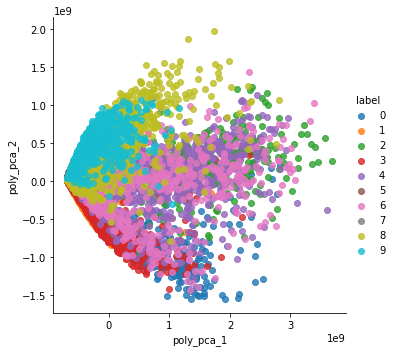

In [174]:
X_train_poly_pca=pd.DataFrame(X_train_poly_pca).loc[:,0:1]
X_train_poly_pca=pd.concat((X_train_poly_pca, y_train), axis=1) 
X_train_poly_pca.columns=['poly_pca_1', 'poly_pca_2', 'label']

sns.lmplot(x='poly_pca_1',y='poly_pca_2',data=X_train_poly_pca,hue='label',fit_reg=False)
plt.show()

## ISOMAP
- 지오데식 거리를 최대한 보존하는 저차원의 공간을 찾자

In [80]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

60.2228sec


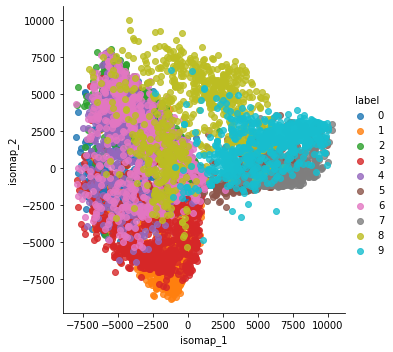

In [81]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

## LLE
- 주변 이웃들의 관계를 저차원에서도 그대로 유지하는 저차원 공간을 찾자

n_neighbors = 5

In [149]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, n_neighbors = 5, random_state=42)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

11.0536sec


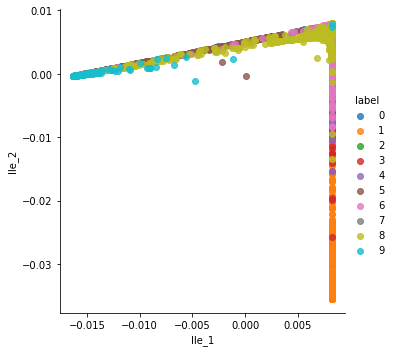

In [150]:
X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

n_neighbors = 20

In [175]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle2 = LocallyLinearEmbedding(n_components=2, n_neighbors = 3, random_state=42)
X_train_lle2 = lle2.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

7.6349sec


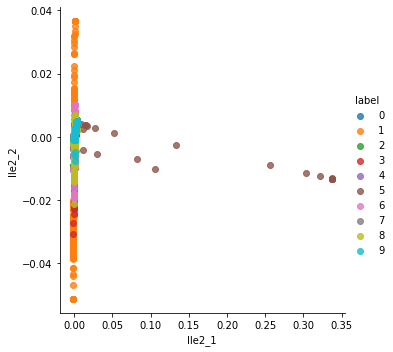

In [176]:
X_train_lle2=pd.DataFrame(X_train_lle2).loc[:,0:1]
X_train_lle2=pd.concat((X_train_lle2, y_train), axis=1) 
X_train_lle2.columns=['lle2_1', 'lle2_2', 'label']
X_train_lle2

sns.lmplot(x='lle2_1',y='lle2_2',data=X_train_lle2,hue='label',fit_reg=False)
plt.show()

## t-SNE
- 주변 이웃들과의 확률적 관계를 그대로 유지해주는 저차원의 공간을 찾자

In [215]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=1)
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

90.2788sec


In [216]:
#나중에 사용할 것
X_train_tsne2 = X_train_tsne

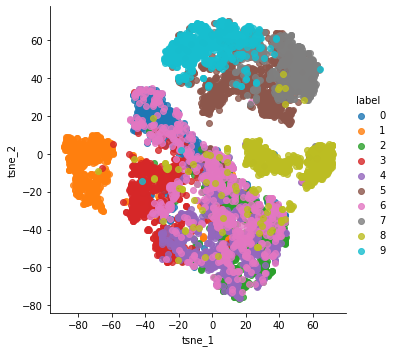

In [217]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

2차원으로 차원을 축소하여 시각화한 결과, t-SNE가 가장 성능이 좋아보인다. <br> 다른 기법들에 비해 클러스터 간 거리는 멀고, 클러스터 내 거리는 가까운 것을 확인할 수 있다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

가장 분류를 잘 한 t-SNE를 살펴보자. 그림을 보면 8번과 1번에 대한 분류를 굉장히 잘 한 것을 볼 수 있다. <br>
반면 0, 2, 4, 6번 레이블의 데이터들은 중앙에 밀집되어 있어 분류를 잘 못 한 것처럼 보인다.

로지스틱 회귀로 분류를 한번 해서 오차행렬을 확인해보자.

In [218]:
X_train_tsne2

array([[ 25.316027,  62.141262],
       [ 29.53763 ,  33.114563],
       [ 16.167269,  37.184296],
       ...,
       [ 19.171078, -60.66784 ],
       [ 59.27186 ,  -7.783624],
       [-26.722353,  25.85389 ]], dtype=float32)

In [219]:
from sklearn.linear_model import LogisticRegression

lr_tsne = LogisticRegression().fit(X_train_tsne2, y_train)
y_pred = lr_tsne.predict(X_train_tsne2)

In [227]:
#정확도 측정
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred))

0.703375


In [228]:
#오차행렬 만들기
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_train, y_pred=y_pred)
print(confmat)

[[658   0  10  92  10   0  19   0  18   0]
 [  7 721   2  31   9   0   7   0   0   0]
 [ 46   0 255   4 208   0 233   0  15   0]
 [ 81   4   3 673  27   0  20   0   2   0]
 [ 16   0 185 102 366   1 110   0   3   0]
 [  8   0   0   0   0 585   2 136   3  72]
 [225   0 201  64  89   1 201   0  37   0]
 [  0   0   0   0   0  50   0 712   1  67]
 [ 19   1  16   7   6  26  15   6 682   1]
 [  1   0   0   1   0  13   0  40   0 774]]


200개 이상의 오분류를 내는 칸 들에 주목하자 

In [229]:
row_index, column_index = np.where((confmat > 200).reshape(10, 10))

In [230]:
print(row_index)
print(column_index)

[0 1 2 2 2 3 4 5 6 6 6 7 8 9]
[0 1 2 4 6 3 4 5 0 2 6 7 8 9]


In [231]:
for i in range(len(row_index)):
  if row_index[i] != column_index[i]: #대각선에 있는 것들은 많을 수록 좋음 - 분류를 잘 한 것들
    print(row_index[i], column_index[i])

2 4
2 6
6 0
6 2


2번을 4번으로, 2번을 6번으로, 6번을 0번으로, 6번을 2번으로 자주 오인하는 것을 확인할 수 있다. 

0 T-shirt/top <br>
2 Pullover <br>
4 Coat <br>
6 Shirt<br>

4가지 항목 모두 상의로, 단순 흑백사진으로는 구분하기 힘들 수도 있다. <br>
Ex) 셔츠와 티셔츠 구분 <br>
(거기다가 차원축소까지 했으니 더욱 구분이 힘들 것이다.)

반면, 1, 8번들은 각각 바지 / 가방으로, 그 형태가 다른 것들과 잘 구분된다. <br>
레이블 리스트에서 상의와 신발은 각각 4, 3 종류나 있으나, 하지만 하의와 가방은 각각 1종류만 있기 때문이다.

수고하셨습니다~